## <center>Elements Of Data Science - F2022</center>
# <center>Week 8: Data Cleaning and Feature Engineering<center>
### <center>10/26/2022</center>

# TODOs

- Readings:
 - PML Ch4.5 : Selecting Meaningful Features
 - PML Ch5.1 : Unsupervised dimensionality reduction via principal component analysis
 - [Recommended] [Pandas: Merge, join, concatenate and compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#)
 - [Additional] PDSH 5.9 : [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
 - [Optional] : Nice ROC visualization (http://www.navan.name/roc/)

<br>
<br>

- **Quiz 8**, due **Tuesday Nov 1st, 11:59pm ET**

- HW2 Due Nov 4th

# Precision & Recall and ROC visualizations
<table>
<tr>
    <td>Precision & Recall<br><img src="images/Precisionrecall.svg.png" width="400px"><br><font size=4>https://www.wikiwand.com/en/Precision_and_recall</font></td>
    <td>ROC<br><img src="images/roc_cutoff-1.gif"><br>This and more at <a href="https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation">https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation</a><br><br>
    Also see the interactive viz at <a href="http://www.navan.name/roc/">http://www.navan.name/roc/</a></td>
</tr>
</table>

# Homework 2 Notes

 - new homework submission points
  -  (1pt) The homework should be spread over multiple pdf pages, not one single pdf page
  -  (1pt) When submitting, assign each question to the pdf page where the solution is printed.\
        If there is no print statement for a question, assign the question to the first pdf 
        page where the code for the question is visible.

 - string formatting vs. `round()` instead for setting precision

In [1]:
import numpy as np

x  = 0.5555
print(f"x                   : {x}")
print(f"using str formatting: {x:0.3f}")
print(f"using round()       : {round(x,3)}")
print(f"using numpy .round(): {np.float64(x).round(3)}") # Use numpy for floats!

x                   : 0.5555
using str formatting: 0.555
using round()       : 0.555
using numpy .round(): 0.556


# Homework 2 Notes Continued

 - creating a dataframe from a dictionary of string:list pairs

In [2]:
import pandas as pd

levels = [2,4,6,8]
vals1 = [0.1,0.2,0.3,0.4]
vals2 = [0.1,0.2,0.2,0.1]
df_tmp = pd.DataFrame({'column1':vals1,'column2':vals2},
                      index=levels
                     )
df_tmp.round(2)

,column1,column2
2,0.1,0.1
4,0.2,0.2
6,0.3,0.2
8,0.4,0.1


# Homework 2 Notes Continued

 - Plotting line plots from a dataframe with numeric columns

,column1,column2
2,0.1,0.1
4,0.2,0.2
6,0.3,0.2
8,0.4,0.1


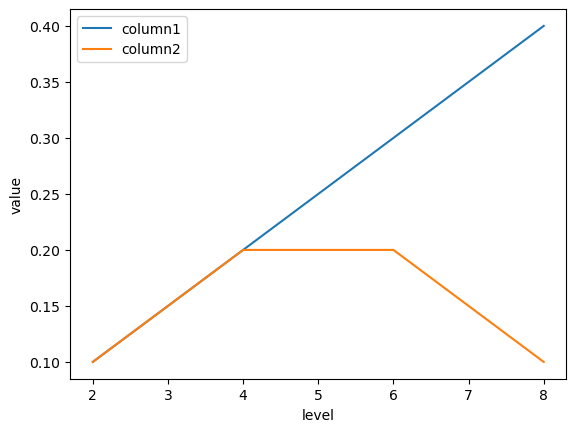

In [3]:
display(df_tmp.round(2))
ax = df_tmp.plot();
ax.set_xlabel('level'); 
ax.set_ylabel('value');

,level,variable,value
0,2,column1,0.1
1,4,column1,0.2
2,6,column1,0.3
3,8,column1,0.4
4,2,column2,0.1
5,4,column2,0.2
6,6,column2,0.2
7,8,column2,0.1


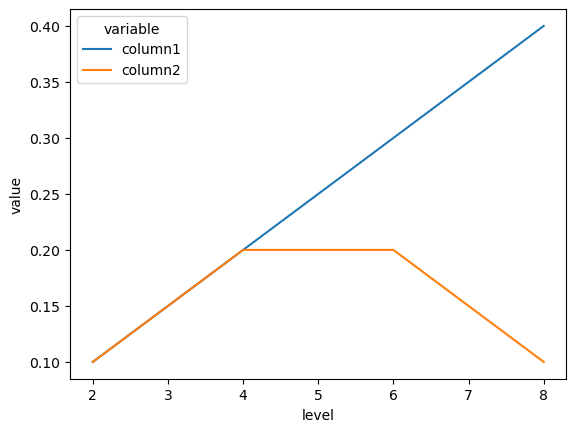

In [4]:
# to do this in seaborn, it's cleanest to transform the data to long format
import seaborn as sns

df_tmp2 = (
    df_tmp
    .rename_axis('level')
    .reset_index()
    .melt(id_vars='level')
)
display(df_tmp2)

sns.lineplot(x='level',y='value',hue='variable',data=df_tmp2);

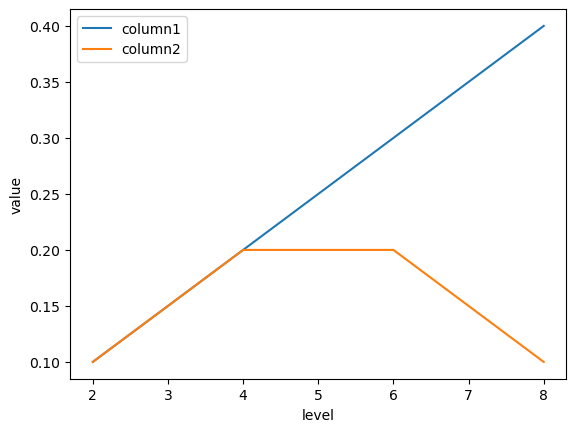

In [5]:
# or we can make two calls to sns.lineplot()
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
sns.lineplot(x=levels,y=vals1,label='column1',ax=ax)
sns.lineplot(x=levels,y=vals2,label='column2',ax=ax)
ax.set_xlabel('level')
ax.set_ylabel('value');

# Notes from Quiz 7

- LinearRegression (regression) vs LogisticRegression (classification)

- using a model "with default settings"

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

# Today

- **Data Cleaning**
 - Duplicates
 - Missing Data
 - Dummy Variables
 - Rescaling
 - Dealing With Skew
 - Removing Outliers
<br>

- **Feature Engineering**
 - Binning
 - One-Hot encoding
 - Derived
   - string functions
   - datetime functions


<br>
<br>

# <center>Questions?</center>
<br>
<br>

# Environment Setup

In [7]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_decision_regions

sns.set_style('darkgrid')

%matplotlib inline

# Data Cleaning
<br>

Why do we need clean data?

- Want one row per observation (need to remove duplicates)
- Most models cannot handle missing data (need to remove/fill missing)
- Most models require fixed length feature vectors (need to engineer features)
<br>

- Different models require different types of data (transformation)
 - Linear models: real valued features with similar scale
 - Distance based: real valued features with similar scale
 - Tree based: can handle unscaled real and categorical (sklearn requires real)

# Example Data

In [8]:
# read in example data
df_shop_raw = pd.read_csv('../data/flowershop_data_with_dups_week8.csv',
                          header=0,
                          delimiter=',')
df_shop_raw['purchase_date'] = pd.to_datetime(df_shop_raw.purchase_date)

# make a copy for editing
df_shop = df_shop_raw.copy()

df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      1001 non-null   int64         
 1   lastname         1001 non-null   object        
 2   purchase_date    1001 non-null   datetime64[ns]
 3   stars            1001 non-null   int64         
 4   price            979 non-null    float64       
 5   favorite_flower  823 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 47.0+ KB


# Duplicated Data
<br>
    
- Only drop duplicates if you know data should be unique
 - Example: if there is a unique id per row

In [9]:
df_shop.duplicated().iloc[-3:] # are any of the last 3 rows duplicates?

998     False
999     False
1000     True
dtype: bool

In [10]:
df_shop[df_shop.duplicated(keep='first')] # default: keep 'first' duplicated row

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil


In [11]:
df_shop[df_shop.duplicated(keep=False)] # keep=False to show all duplicated rows

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
10,1010,FERGUSON,2017-05-04,2,21.02,daffodil
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil


# Duplicated Data for Subset of Columns

In [12]:
# if it's important that a subset of columns is not duplicated
(
    df_shop
    .loc[df_shop.duplicated(subset=['purchase_id'],keep=False)]
    .sort_values(by='purchase_id')
)

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
10,1010,FERGUSON,2017-05-04,2,21.02,daffodil
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil
100,1101,WEBB,2017-07-13,2,8.00,iris
101,1101,BURKE,2017-08-16,4,18.56,daffodil


In [13]:
# could also use the indexing shortcut
df_shop[df_shop.duplicated(subset=['purchase_id'],keep=False)].sort_values(by='purchase_id')

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
10,1010,FERGUSON,2017-05-04,2,21.02,daffodil
1000,1010,FERGUSON,2017-05-04,2,21.02,daffodil
100,1101,WEBB,2017-07-13,2,8.00,iris
101,1101,BURKE,2017-08-16,4,18.56,daffodil


# Dropping Duplicates

In [14]:
df_shop = df_shop.drop_duplicates(subset=None,    # consider all columns
                                  keep='first',   # or 'last' or False)
                                  inplace=False   # default, return a modified dataframe
                                 )

In [15]:
# or can use inplace to change the original dataframe
df_shop.drop_duplicates(subset=None,
                        keep='first',
                        inplace=True # change the dataframe in place
                       )

In [16]:
# can also drop rows with duplicates considering only a subset of columns
df_shop = df_shop.drop_duplicates(subset=['purchase_id'])

# Missing Data

- Reasons for missing data
 - Sensor error (random?)
 - Data entry error (random?)
 - Survey-subject decisions (non-random?)
 - etc.
<br>

- Dealing with missing data
 - Drop rows
 - Impute from data in the same column
 - Infer from other features
 - Fill with adjacent data

# Missing Data in Pandas: `np.nan`
<br>

- Missing values represented by `np.nan` : Not A Number

In [17]:
# Earlier, we saw missing values in the dataframe summary
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      999 non-null    int64         
 1   lastname         999 non-null    object        
 2   purchase_date    999 non-null    datetime64[ns]
 3   stars            999 non-null    int64         
 4   price            977 non-null    float64       
 5   favorite_flower  821 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 54.6+ KB


In [18]:
# can we check for NaN using "x == np.nan"? No!
np.nan == np.nan

False

In [19]:
# however
np.nan is np.nan

True

# How to check for NaN: `.isna()` and `.notna()`

In [20]:
# some missing data
df_shop.loc[20:21,'price']

20      NaN
21    10.53
Name: price, dtype: float64

In [21]:
# .isna() returns True where data is missing, False otherwise
df_shop.loc[20:21,'price'].isna()

20     True
21    False
Name: price, dtype: bool

In [22]:
# .notna() returns True where data is NOT missing, False otherwise
df_shop.loc[20:21,'price'].notna()

20    False
21     True
Name: price, dtype: bool

In [23]:
# find rows where price is missing
df_shop[df_shop.price.isna()].head()

,purchase_id,lastname,purchase_date,stars,price,favorite_flower
20,1020,CLARK,2017-01-05,3,NaN,NaN
41,1041,PETERS,2017-02-01,4,NaN,orchid
54,1054,GREEN,2017-02-13,5,NaN,daffodil
63,1063,BARNETT,2017-08-27,4,NaN,gardenia
145,1145,CARROLL,2017-07-29,3,NaN,tulip


# Counting NaNs

In [24]:
# How many nan's in a single column?
df_shop.price.isna().sum()

22

In [25]:
# How many nan's per column?
df_shop.isna().sum()

purchase_id          0
lastname             0
purchase_date        0
stars                0
price               22
favorite_flower    178
dtype: int64

In [26]:
# How many total nan's?
df_shop.isna().sum().sum()

200

# Missing Data: Drop Rows

In [27]:
df_shop.shape

(999, 6)

In [28]:
# drop rows with nan in any column
df_shop.dropna().shape

(801, 6)

In [29]:
# drop only rows with nan in price using subset
df_shop.dropna(subset=['price']).shape

(977, 6)

In [30]:
# drop only rows with nans in all columns (a row of all nans)
df_shop.dropna(how='all').shape

(999, 6)

# Missing Data: Drop Rows Cont.

In [31]:
# save a new dataframe with dropped rows
df_shop = df_shop.dropna()
df_shop.shape

(801, 6)

In [32]:
# drop rows in current dataframe
df_shop = df_shop_raw.drop_duplicates().copy()

df_shop.dropna(inplace=True)
df_shop.shape

(802, 6)

# Missing Data: Drop Rows
<br>

- Pros:
 - easy to do
 - simple to understand
<br>
<br>

- Cons:
 - potentially large data loss

# Missing Data: Fill with Constant

- Use .fillna()
- Common filler: 0, -1

In [33]:
df_shop = df_shop_raw.drop_duplicates().copy() # make a new copy of the data

In [34]:
df_shop.price[20:22]

20      NaN
21    10.53
Name: price, dtype: float64

In [35]:
df_shop.price[20:22].fillna(0)

20     0.00
21    10.53
Name: price, dtype: float64

In [36]:
print(df_shop.price.mean().round(2))
print(df_shop.price.fillna(0).mean().round(2))

23.4
22.89


# Missing Data: Fill with Constant

Pros:

- easy to do
- simple to understand

Cons:

- values may not be realistic

# Missing Data: Impute
<br>

- Impute: fill with value infered from existing values in that column
<br>

- Use .fillna() or sklearn methods
<br>

- Common filler values:
 - mean
 - median
 - "most frequent" aka mode

# Missing Data: Impute

In [37]:
print(df_shop.price.mean().round(2))
print(df_shop.price.fillna(df_shop.price.mean()).mean().round(2))

23.4
23.4


In [38]:
# make a copy to keep our original df
df_shop_impute = df_shop.copy()

In [39]:
# fill missing price with mean of price
df_shop_impute['price'] = df_shop.price.fillna(df_shop.price.mean())

In [40]:
# check to make sure all nulls filled
assert df_shop_impute.price.isna().sum() == 0
assert df_shop_impute.price.notna().all()

# also, that our mean hasn't changed
assert df_shop.price.mean() == df_shop_impute.price.mean() 

In [41]:
# inplace works here as well
df_shop_impute.price.fillna(df_shop_impute.price.mean(),inplace=True)

# Missing Data: Impute Cont.

In [42]:
df_shop.favorite_flower.mode() # may be more than 1!

0    lilac
Name: favorite_flower, dtype: object

In [43]:
# Note that we have to index into the DataFrame returned by mode to get a value
df_shop_impute.favorite_flower.fillna(df_shop_impute.favorite_flower.mode().iloc[0],inplace=True)

df_shop_impute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   purchase_id      1000 non-null   int64         
 1   lastname         1000 non-null   object        
 2   purchase_date    1000 non-null   datetime64[ns]
 3   stars            1000 non-null   int64         
 4   price            1000 non-null   float64       
 5   favorite_flower  1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 54.7+ KB


# Missing Data: Impute Cont. Using SimpleImputer

In [44]:
df_shop[['price','stars']].loc[20:22]

,price,stars
20,NaN,3
21,10.53,2
22,19.77,1


In [45]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean').fit(df_shop[['price','stars']])
print(f'fill values = {imp.statistics_.round(2)}')
imp.transform(df_shop.loc[20:22,['price','stars']]).round(2)

fill values = [23.4  3.6]


array([[23.4 ,  3.  ],
       [10.53,  2.  ],
       [19.77,  1.  ]])

In [46]:
df_shop.favorite_flower[:3]

0         iris
1          NaN
2    carnation
Name: favorite_flower, dtype: object

In [47]:
imp = SimpleImputer(strategy='most_frequent').fit(df_shop[['favorite_flower']])
imp.transform(df_shop.loc[:2,['favorite_flower']])

array([['iris'],
       ['lilac'],
       ['carnation']], dtype=object)

# Missing Data: Impute
<br>

- Pros:
 - easy to do
 - simple to understand
<br>
<br>

- Cons:
 - may missing feature interactions

# Missing Data: Infer
<br>

- Predict values of missing features using a model
- Ex: Can we predict price based on any of the other features?
- Additional feature engineering may be needed prior to this

In [48]:
from sklearn.linear_model import LinearRegression

df_shop_infer = df_shop.copy()

not_missing = df_shop_infer.price.notna()
missing     = df_shop_infer.price.isna()

lr = LinearRegression().fit(df_shop_infer.loc[not_missing,['stars']],
                            df_shop_infer.loc[not_missing,'price'])

df_shop_infer.loc[missing,'price'] = lr.predict(df_shop_infer.loc[missing,['stars']])

# Missing Data: Impute

<br>

- Pros:
 - better estimate (based on other data)
<br>
<br>

- Cons:
 - have to train another model
 - colinear features!

# Missing Data: Adjacent Data
<br>

- Use `.fillna()` with method:
 - ffill: propagate last valid observation forward to next valid
 - bfill: use next valid observation to fill gap backwards
<br>

- Use when there is reason to believe data not i.i.d. (eg: timeseries)

In [49]:
df_shop.price.loc[19:21]

19    20.45
20      NaN
21    10.53
Name: price, dtype: float64

In [50]:
df_shop.price.fillna(method='ffill').loc[19:21]

19    20.45
20    20.45
21    10.53
Name: price, dtype: float64

# Missing Data: Add a Dummy Column First
<br>

- Data may be missing for a reason!
- Capture "missing" before filling

In [51]:
df_shop = df_shop_raw.drop_duplicates().copy()

# storing a column of 1:missing, 0:not-missing
df_shop['price_missing'] = df_shop.price.isna().astype(int)

# can now fill missing values
df_shop['price'] = df_shop.price.fillna(df_shop.price.mean())

In [52]:
# finding where data was missing
np.where(df_shop.price_missing == 1)

(array([ 20,  41,  54,  63, 145, 186, 194, 203, 212, 360, 367, 382, 429,
        469, 522, 570, 595, 726, 792, 821, 974, 978]),)

In [53]:
df_shop[['price','price_missing']].iloc[20:23]

,price,price_missing
20,23.403384,1
21,10.530000,0
22,19.770000,0


# Rescaling
<br>

- Often need features to be in the same scale
- Methods of rescaling
 - Standardization (z-score)
 - Min-Max rescaling
 - others...

In [54]:
# load taxi data
df_taxi_raw = pd.read_csv('../data/yellowcab_tripdata_2017-01_subset10000rows.csv',
                          parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'])
# create trip_duration
df_taxi_raw['trip_duration'] = (df_taxi_raw.tpep_dropoff_datetime - df_taxi_raw.tpep_pickup_datetime).dt.seconds

# select subset
df_taxi_raw = df_taxi_raw[df_taxi_raw.trip_duration.lt(3600) & 
                          df_taxi_raw.tip_amount.between(0,10,inclusive='neither')]
                           
df_taxi = df_taxi_raw.copy()

In [55]:
df_taxi[['trip_duration','tip_amount']].agg(['mean','std','min','max'],axis=0).round(2)

,trip_duration,tip_amount
mean,765.03,2.41
std,496.83,1.55
min,2.00,0.01
max,3556.00,9.99


# Rescaling: Standardization
<br>

- rescale to 0 mean, standard deviation of 1
 - X_scaled = (X - X.mean()) / X.std()

In [56]:
from sklearn.preprocessing import StandardScaler

# instantiate
ss = StandardScaler(with_mean=True, with_std=True) # default is center and scale

# fit to the data
ss.fit(df_taxi[['trip_duration','tip_amount']])

# transform the data
X_ss = ss.transform(df_taxi[['trip_duration','tip_amount']])
X_ss[:2].round(2)

array([[-0.5 , -0.48],
       [-0.17, -0.91]])

In [57]:
df_taxi_ss = pd.DataFrame(X_ss,columns=['trip_duration_scaled','tip_amount_scaled'])
df_taxi_ss.agg(['mean','std','min','max'],axis=0).round(2)

,trip_duration_scaled,tip_amount_scaled
mean,0.00,-0.00
std,1.00,1.00
min,-1.54,-1.54
max,5.62,4.88


# Rescaling: Min-Max

- rescale values between 0 and 1
- X_scaled = (X - X.min()) / (X.max() - X.min())
- removes negative values

In [58]:
from sklearn.preprocessing import MinMaxScaler

X_mms = MinMaxScaler(feature_range=(0,1) # default is to rescale between 0 and 1
                    ).fit_transform(df_taxi[['trip_duration','tip_amount']])

df_taxi_mms = pd.DataFrame(X_mms,columns=['trip_duration_scaled','tip_amount_scaled'])
df_taxi_mms.agg(['mean','std','min','max']).round(2)

,trip_duration_scaled,tip_amount_scaled
mean,0.21,0.24
std,0.14,0.16
min,0.00,0.00
max,1.00,1.00


# Dealing with Skew
<br>

- Many models expect "normal", symmetric data (ex: linear models)
- Highly skewed: tail has larger effect on model (outliers?)
- Transform with `log` or `sqrt`


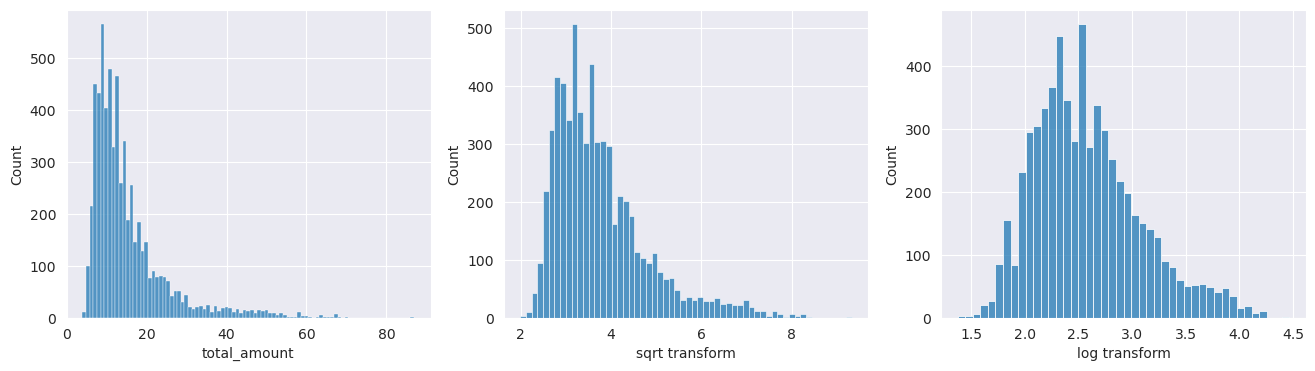

In [59]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
sns.histplot(x=df_taxi.total_amount, ax=ax[0]);
sns.histplot(x=df_taxi.total_amount.apply(np.sqrt), ax=ax[1]); ax[1].set_xlabel('sqrt transform');
sns.histplot(x=df_taxi.total_amount.apply(np.log),  ax=ax[2]); ax[2].set_xlabel('log transform');

# Outliers

- Similar to missing data:
 - human data entry error
 - instrument measurement errors
 - data processing errors
 - natural deviations


<div align="center"><img src="images/outlier-detection-1.png" width="600px"></div>

# Outliers
<br>

- Why worry about them?
 - can give misleading results
 - can indicate issues in data/measurement
<br>
<br>

- Detecting Outliers
 - understand your data!
 - visualizations
 - 1.5*IQR
 - z-scores
 - etc..

# Detecting Outliers

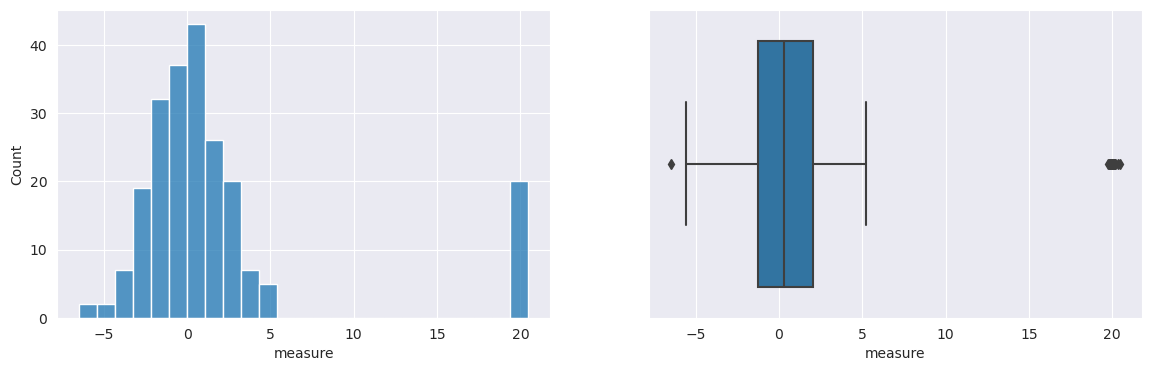

In [60]:
np.random.seed(123)
data_rand = np.concatenate([np.random.normal(0,2,200),np.random.normal(20,.2,20)])
df_rand = pd.DataFrame({'measure':data_rand})

fig,ax = plt.subplots(1,2, figsize=(14,4))
sns.histplot(x=df_rand.measure,ax=ax[0]);sns.boxplot(x=df_rand.measure,ax=ax[1]);

In [61]:
# Calculating IQR
p25,p75 = df_rand.measure.quantile([.25,.75])
iqr = p75 - p25
round(iqr,2)

3.3

In [62]:
# Finding outliers with IQR (first two examples found)
df_rand.measure[(df_rand.measure > p75+(1.5*iqr)) | (df_rand.measure < p25-(1.5*iqr))].sort_values().head(2).round(2)

195    -6.46
213    19.72
Name: measure, dtype: float64

# Detecting Outliers with z-score

,measure,measure_zscore
213,19.72,2.93
207,19.82,2.94
218,19.85,2.95


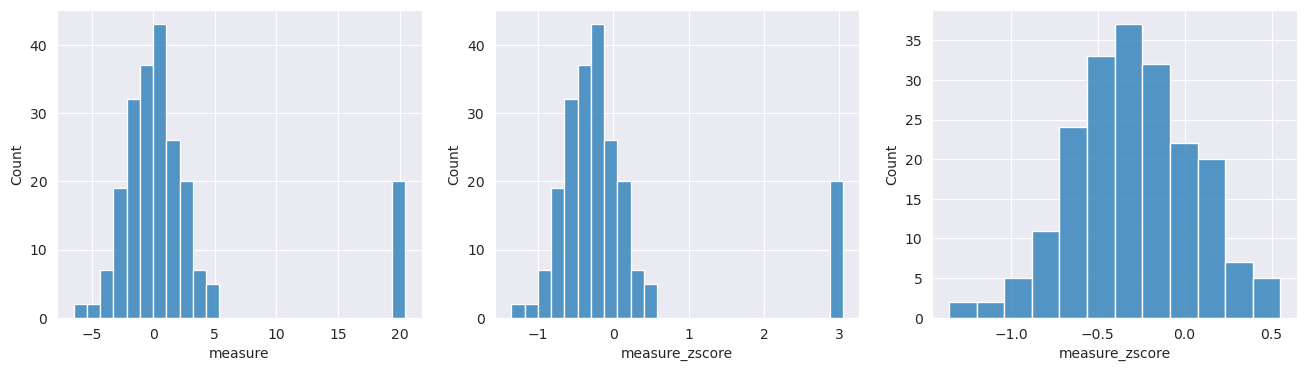

In [63]:
# zscore
df_rand['measure_zscore'] = (df_rand.measure - df_rand.measure.mean()) / df_rand.measure.std()

fig, ax = plt.subplots(1,3,figsize=(16,4))
sns.histplot(x=df_rand.measure,ax=ax[0]);
sns.histplot(x=df_rand.measure_zscore, ax=ax[1]);

keep_idx = np.abs(df_rand.measure_zscore) < 2
sns.histplot(x=df_rand[keep_idx].measure_zscore, ax=ax[2]);

# sample of points getting dropped
df_rand[np.abs(df_rand.measure_zscore) >= 2].sort_values(by='measure').head(3).round(2)

# Other Outlier Detection Methods
<br>

- Many more parametric and non-parametric methods
 - Standardized Residuals
 - DBScan
 - ElipticEnvelope
 - IsolationForest
 - other Anomoly Detection techniques
 - See [sklearn docs on Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html) for more details

# Dealing with Outliers
<br>

- How to deal with outliers?
 - drop data
 - treat as missing
 - encode with dummy variable first

# Putting It All Together: Different Styles

In [64]:
df_shop1 = pd.read_csv('../data/flowershop_data_with_dups_week8.csv')
df_shop1 = df_shop1.drop_duplicates()
df_shop1['purchase_date']           = pd.to_datetime(df_shop1.purchase_date)
df_shop1['price_missing']           = df_shop1.price.isna().astype(int)
df_shop1['price']                   = df_shop1.price.fillna(df_shop1.price.mean())
df_shop1['price_scaled']            = StandardScaler().fit_transform(df_shop1[['price']])
df_shop1['favorite_flower_missing'] = df_shop1.favorite_flower.isna().astype(int)
df_shop1['favorite_flower']         = SimpleImputer(strategy='most_frequent').fit(df_shop1[['favorite_flower']])

In [65]:
df_shop2 = (
    pd.read_csv('../data/flowershop_data_with_dups_week8.csv')
    .drop_duplicates()
    .assign(
        purchase_date           = lambda df_ : pd.to_datetime(df_.purchase_date),
        price_missing           = lambda df_ : df_.price.isna().astype(int),
        price                   = lambda df_ : df_.price.fillna(df_.price.mean()),
        price_scaled            = lambda df_ : StandardScaler().fit_transform(df_[['price']]),
        favorite_flower_missing = lambda df_ : df_.favorite_flower.isna().astype(int),
        favorite_flower         = lambda df_ : (SimpleImputer(strategy='most_frequent')
                                                .fit_transform(df_shop1[['favorite_flower']])
                                               )
    )
)

In [66]:
pd.testing.assert_frame_equal(df_shop1,df_shop2) # throws an exeption when data frames are not the same 

# Data Cleaning Review

- duplicate data
- missing data
- rescaling
- dealing with skew
- outlier detection

# Feature Engineering
<br>

- Binning
- One-Hot encoding
- Derived Features

# Binning
<br>

- Transform continuous features to categorical
- Use:
 - pd.cut
 - sklearn.preprocessing.KBinsDiscretizer (combined binning and one-hot-encoding)

In [67]:
trip_duration_bins = [df_taxi.trip_duration.min(),
                      df_taxi.trip_duration.median(),
                      df_taxi.trip_duration.quantile(0.75),
                      df_taxi.trip_duration.max(),]

In [68]:
df_taxi_bin = df_taxi_raw.copy()
df_taxi_bin['trip_duration_binned'] = pd.cut(df_taxi_bin.trip_duration,           
                                             bins=trip_duration_bins,          # can pass bin edges or number of bins
                                             labels=['short','medium','long'],
                                             right=True,                       # all bins right-inclusive
                                             include_lowest=True               # first interval left-inclusive
                                            )
df_taxi_bin[['trip_duration','trip_duration_binned']].iloc[:3]


,trip_duration,trip_duration_binned
1,516,short
2,683,medium
7,834,medium


# One-Hot Encoding

- Encode categorical features for models that can't handle categorical (eg. Linear)
- One column per category, '1' in only one column per row
- Use `pd.get_dummies()` or `sklearn.preprocessing.OneHotEncoder`

In [69]:
pd.get_dummies(df_taxi_bin.trip_duration_binned, prefix='trip_duration').iloc[:2]

,trip_duration_short,trip_duration_medium,trip_duration_long
1,1,0,0
2,0,1,0


In [70]:
# to add back to dataframe, use join (will discuss .join() next time)
df_taxi_bin.join(pd.get_dummies(df_taxi_bin.trip_duration_binned, prefix='trip_duration')).iloc[:2,-6:] # not saved

,total_amount,trip_duration,trip_duration_binned,trip_duration_short,trip_duration_medium,trip_duration_long
1,9.96,516,short,1,0,0
2,10.30,683,medium,0,1,0


In [71]:
# or let pandas determine which columns to one-hot
pd.get_dummies(df_taxi_bin).iloc[:2,-6:] # not being saved

,trip_duration,store_and_fwd_flag_N,store_and_fwd_flag_Y,trip_duration_binned_short,trip_duration_binned_medium,trip_duration_binned_long
1,516,1,0,1,0,0
2,683,1,0,0,1,0


# One-Hot Encoding with sklearn

In [72]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories=[['short','medium','long']],  # or leave as 'auto'
                    sparse=True,
                    handle_unknown='ignore')                 # will raise error otherwise

ohe.fit(df_taxi_bin[['trip_duration_binned']])
ohe.categories_

[array(['short', 'medium', 'long'], dtype=object)]

In [73]:
ohe.transform(df_taxi_bin[['trip_duration_binned']])[:3] # returns a sparse matrix!

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [74]:
ohe.transform(df_taxi_bin[['trip_duration_binned']])[:3].todense() # use .todense() to convert sparse to dense

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

# Bin and One-Hot Encode with sklearn

In [75]:
from sklearn.preprocessing import KBinsDiscretizer

# NOTE: We're not setting the bin edges explicitly
#       For control over bin edges, use Binarizer
kbd = KBinsDiscretizer(n_bins=3,
                       encode="onehot",     # or onehot (sparse), ordinal
                       strategy="quantile", # or uniform or kmeans (clustering)
                      ).fit(df_taxi[['trip_duration']])
print(kbd.bin_edges_)
print(kbd.bin_edges_[0].astype(int))

[array([2.000e+00, 4.780e+02, 8.700e+02, 3.556e+03])]
[   2  478  870 3556]


In [76]:
df_taxi[['trip_duration']].tail(3)

,trip_duration
9994,905
9995,296
9997,2089


In [77]:
kbd.transform(df_taxi[['trip_duration']])[-3:]

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [78]:
kbd.transform(df_taxi[['trip_duration']])[-3].todense()

matrix([[0., 0., 1.]])

# Dealing with Ordinal Variables

In [79]:
df_pml = pd.DataFrame([['green','M',10.1,'class2'],
                       ['red','L',13.5,'class1'],
                       ['blue','XL',15.3,'class2']],
                      columns=['color','size','price','classlabel'])
df_pml

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [80]:
# if we know the numerical difference between ordinal values
# eg XL = L+1 = M+2

size_mapping = {'XL':3,
                'L':2,
                'M':1}

df_pml_features = pd.DataFrame()

df_pml_features['size'] = df_pml['size'].map(size_mapping)
df_pml_features

,size
0,1
1,2
2,3


# Dealing with Ordinal Variables Cont.

In [81]:
df_pml

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [82]:
# if we don't know the numerical difference between ordinal values
# generate threshold features
df_pml_features = pd.DataFrame()
df_pml_features['x > M'] = df_pml['size'].apply(lambda x: 1 if x in ['L','XL'] else 0)
df_pml_features['x > L'] = df_pml['size'].apply(lambda x: 1 if x == 'XL' else 0)
df_pml_features

,x > M,x > L
0,0,0
1,1,0
2,1,1


# Derived Features
<br>

- Anything that is a transformation of our data
- This is where the money is!

- Examples:
    - "is a high demand pickup location"
    - "is a problem house sale"
    - "high-performing job candidate"

# Polynomial Features

In [83]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2,
                        include_bias=False)
X_new = pf.fit_transform(df_taxi[['passenger_count','trip_duration']])

new_columns = ['passenger_count','trip_duration','passenger_count^2','passenger_count*trip_duration','trip_duration^2']
pd.DataFrame(X_new[3:5],columns=new_columns)

,passenger_count,trip_duration,passenger_count^2,passenger_count*trip_duration,trip_duration^2
0,3.0,298.0,9.0,894.0,88804.0
1,1.0,396.0,1.0,396.0,156816.0


# Python String Functions

In [84]:
doc = "D.S. is great!"
doc

'D.S. is great!'

In [85]:
doc.lower(),doc.upper()       # change capitalization

('d.s. is great!', 'D.S. IS GREAT!')

In [86]:
doc.split() , doc.split('.')  # split a string into parts (default is whitespace)

(['D.S.', 'is', 'great!'], ['D', 'S', ' is great!'])

In [87]:
'|'.join(['ab','c','d'])      # join items in a list together

'ab|c|d'

In [88]:
'|'.join(doc[:5])             # a string itself is treated like a list of characters

'D|.|S|.| '

In [89]:
'  test   '.strip()           # remove whitespace from the beginning and end of a string

'test'

and more, see [https://docs.python.org/3.8/library/string.html](https://docs.python.org/3.8/library/string.html)

# String Functions in Pandas

In [90]:
df_shop.iloc[:2].loc[:,'lastname']

0     PERKINS
1    ROBINSON
Name: lastname, dtype: object

In [91]:
df_shop.loc[:,'lastname'].iloc[:2].str.lower()

0     perkins
1    robinson
Name: lastname, dtype: object

In [92]:
df_shop.lastname[:2].str.capitalize()

0     Perkins
1    Robinson
Name: lastname, dtype: object

In [93]:
df_shop.lastname[:2].str.startswith('ROB') # .endswith() , .contains()

0    False
1     True
Name: lastname, dtype: bool

In [94]:
df_shop.lastname[:2].str.replace('R','^')

0     PE^KINS
1    ^OBINSON
Name: lastname, dtype: object

and more: [https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#method-summary](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#method-summary)

# Pandas datetime functions

In [95]:
df_taxi.iloc[:2].tpep_pickup_datetime

1   2017-01-05 15:14:52
2   2017-01-11 14:47:52
Name: tpep_pickup_datetime, dtype: datetime64[ns]

In [96]:
df_taxi.iloc[:2].tpep_pickup_datetime.dt.day

1     5
2    11
Name: tpep_pickup_datetime, dtype: int64

In [97]:
df_taxi.iloc[:2].tpep_pickup_datetime.dt.day_of_week

1    3
2    2
Name: tpep_pickup_datetime, dtype: int64

In [98]:
(df_taxi.tpep_dropoff_datetime - df_taxi.tpep_pickup_datetime).dt.seconds.iloc[:2]

1    516
2    683
dtype: int64

In [99]:
(pd.to_datetime('today') - df_taxi.tpep_dropoff_datetime).dt.days.div(365).iloc[:2].round(2)

1    5.81
2    5.79
Name: tpep_dropoff_datetime, dtype: float64

and more: [https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components)

# Transforming with Train/Test Split
<br>
- When performing data transformation

<div align="center"><img src="images/transformation_pipeline.png" width="800px"></div>

# Predicting with Train/Test Split
<br>
- When training a model for prediction

<div align="center"><img src="images/modelpredict_pipeline.png" width="600px"></div>

# Next Time

- Dimensionality Reduction
  - Feature Selection
  - Feature Extraction


<br>
<br>

# <center>Questions?</center>
<br>
<br>